In [1]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Importing VGG19 pretrained

In [3]:
model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Preprocessing the input images

If size is an int, smaller edge of the image will be matched to this number.

Given mean: $(mean[1],...,mean[n])$ and std: $(std[1],..,std[n])$ for $n$ channels, this transform will normalize each channel of the input i.e.: $$output[channel] = (input[channel] - mean[channel]) / std[channel]$$

In [4]:
transform = transforms.Compose([transforms.Resize(300),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [5]:
content = Image.open("content.jpg").convert("RGB")
content = transform(content).to(device)
# print("COntent shape => ", content.shape)
style = Image.open("style.jpg").convert("RGB")
style = transform(style).to(device)

#### Showing the input images (content and style)

In [6]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

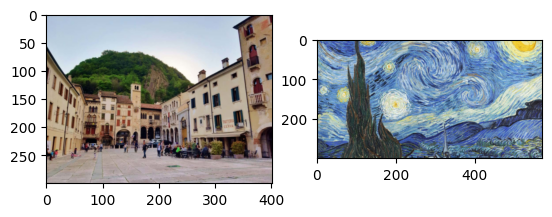

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content), label = "Content")
ax2.imshow(imcnvt(style), label = "Style")
plt.show()

### Defining the output image

In [8]:
target = content.clone().requires_grad_(True).to(device)

### Making sure the device is ready

In [9]:
print("device = ",device)

device =  cpu


### Collecting content and style features

Following the paper's guidelines, the content representation of the image is collected at the second convolution of the fourth layer, $conv4\_2$, so it only uses a single layer of the network.
On the other hand, the style representation is given by a number of layers of the CNN, hence why we need $conv1\_1$, $conv2\_1$, $conv3\_1$, $conv4\_1$, $conv5\_1$.

![VGG19](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg "VGG 19")

In [10]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2', # Content representation extracted from here
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

In [11]:
content_features = model_activations(content, model)
style_features = model_activations(style, model)

### Defining Loss functions and computation of final image

An image is encoded in each layer of the CNN by the filter responses to that image. <br>
A layer with $N_l$ filters has $N_l$ feature maps, each of size $M_l$ (height times width of the feature maps). So the responses in a layer $l$ can be stored in a matrix $$F^l \in R^{N_l \times M_l}$$ where $F_{ij}^l$ is the activation of the $i$-th filter at position $j$ in layer $l$

The style representation computes the correlations between different filter responses. These expectations are given by the Gram matrix, one for each layer, which is a square matrix where each element represents the inner product between the vectorised feature map $i$ and $j$ in that layer $l$. $$G_{ij}^l = \sum_k F_{ik}^lF_{jk}^l$$ 

In [12]:
def gram_matrix(imgfeature):
    _, d, h, w = imgfeature.size()
    imgfeature = imgfeature.view(d, h*w)
    gram_mat = torch.mm(imgfeature, imgfeature.t())
    
    return gram_mat

The global loss function we minimise is: $$L_{total}(p,a,x) = \alpha L_{content}(p,x) + \beta L_{style}(a,x)$$ where the ratio $\alpha / \beta$ should be either $0.001$ or $0.0001$, $p$ is the original content image, $a$ is the original style image, and $x$ is the generated image proposal. 

In [13]:
content_wt = 100
style_wt = 1e5

We define: $$L_{content}(p,x,l) = \frac{1}{2} \sum_{i,j}(F_{ij}^l - P_{ij}^l)^2$$ where $P^l$ is the representation of the content image in layer $l$ and $F^l$ is the representation of the generated image in that layer $$L_{style}(a,x) = \sum_{l=0}^L \omega_lE_l$$ Where all 5 selected layers have equal weight, and others are all set to zero, and $E_l$ is the contribution of each style layer to the total loss, and is defined as: $$ E_l = \frac{1}{4N_l^2M_l^2} \sum_{ij} (G_{ij}^l - A_{ij}^l)^2$$

In [14]:
style_wt_meas = {"conv1_1" : 0.2, 
                "conv2_1" : 0.2,
                "conv3_1" : 0.2,
                "conv4_1" : 0.2,
                "conv5_1" : 0.2}

style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

In [15]:
optimizer = torch.optim.Adam([target], lr = 0.007)

### Executing for multiple epochs and printing intermediate results

epoch  500   tensor(1865692.8750, grad_fn=<AddBackward0>)


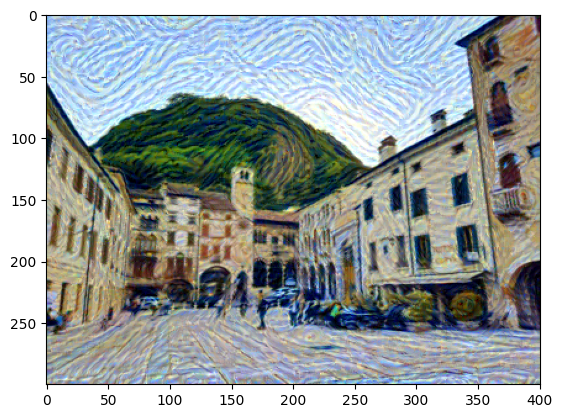

epoch  1000   tensor(959463.8750, grad_fn=<AddBackward0>)


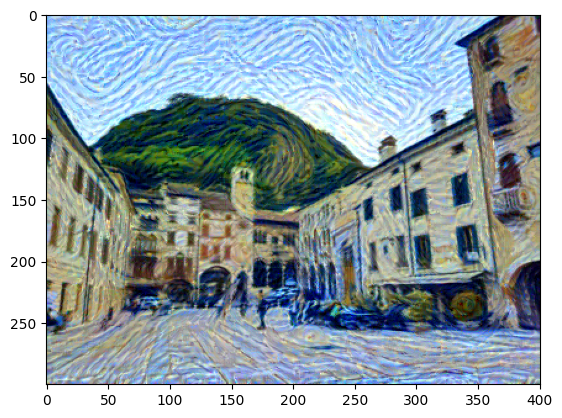

epoch  1500   tensor(700963.3750, grad_fn=<AddBackward0>)


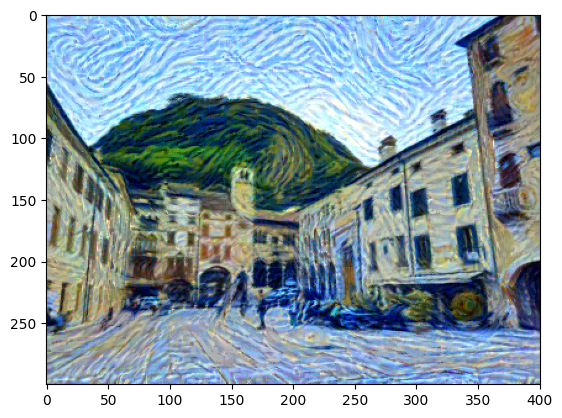

epoch  2000   tensor(600802.0625, grad_fn=<AddBackward0>)


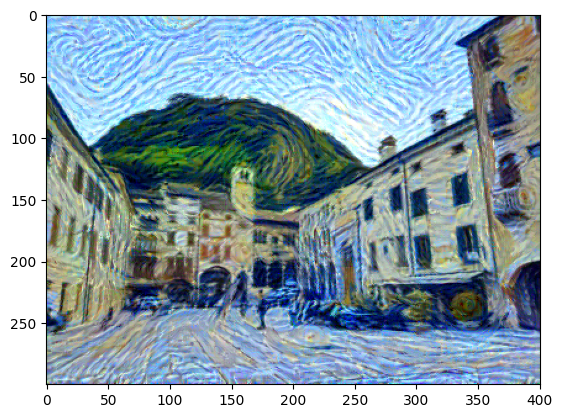

epoch  2500   tensor(538310.9375, grad_fn=<AddBackward0>)


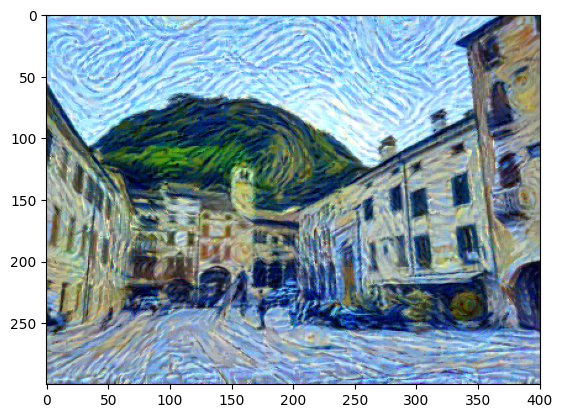

epoch  3000   tensor(491592.5938, grad_fn=<AddBackward0>)


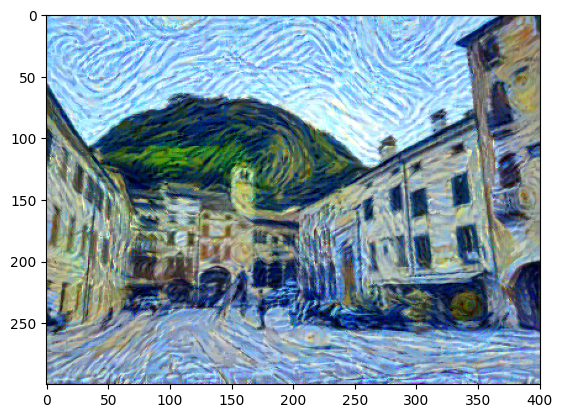

epoch  3500   tensor(455524.3125, grad_fn=<AddBackward0>)


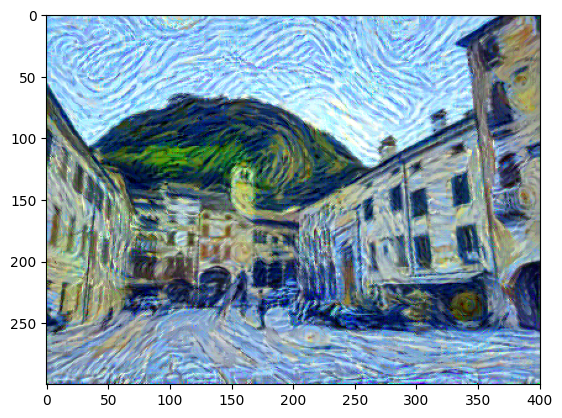

epoch  4000   tensor(427599.2188, grad_fn=<AddBackward0>)


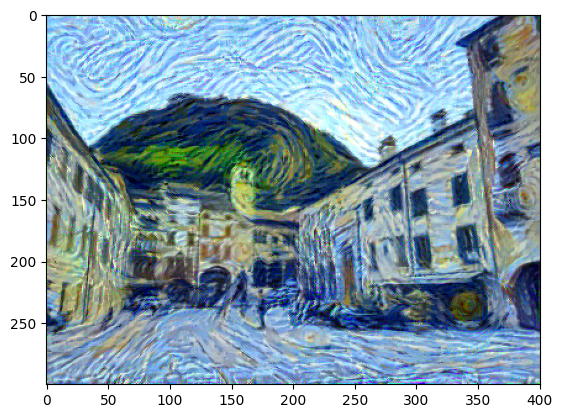

epoch  4500   tensor(400401., grad_fn=<AddBackward0>)


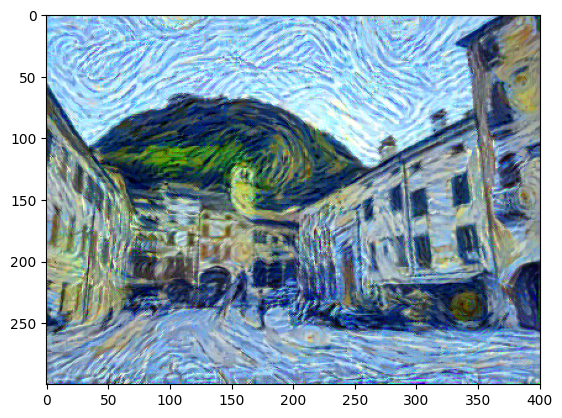

epoch  5000   tensor(377409.0938, grad_fn=<AddBackward0>)


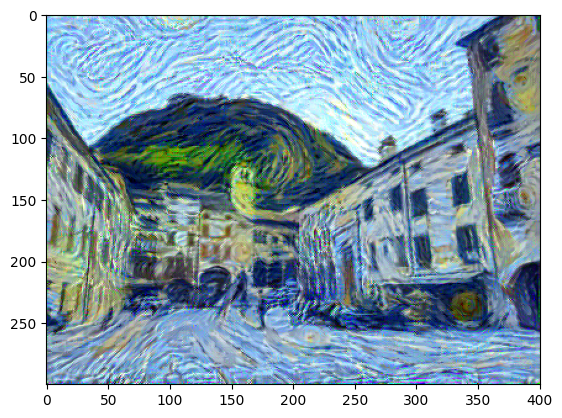

epoch  5500   tensor(362467.7188, grad_fn=<AddBackward0>)


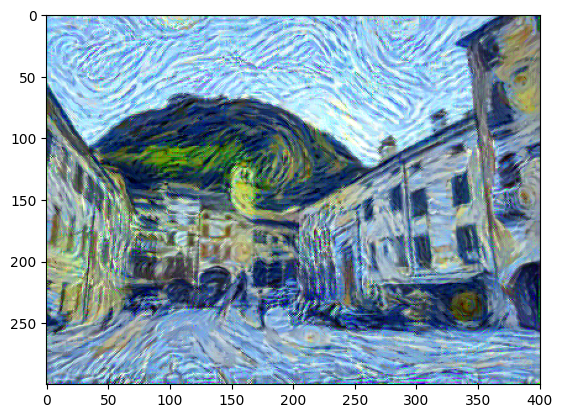

epoch  6000   tensor(349453.9688, grad_fn=<AddBackward0>)


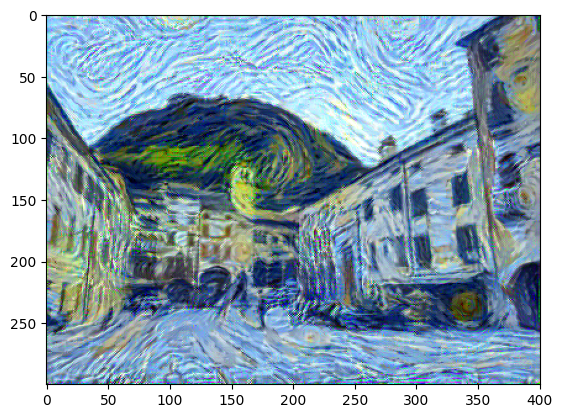

epoch  6500   tensor(331291.3750, grad_fn=<AddBackward0>)


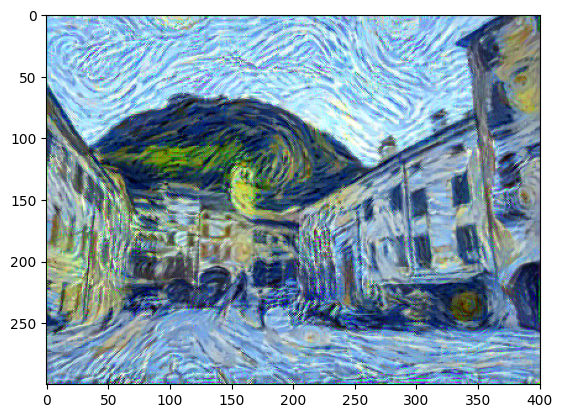

epoch  7000   tensor(325941.1562, grad_fn=<AddBackward0>)


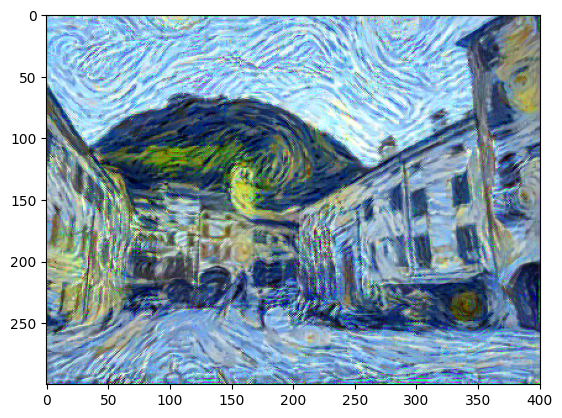

In [16]:
print_every = 500
epochs = 7000

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _, d, w, h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_layer_loss = torch.mean((target_gram-style_gram)**2) / (4 * w * h)

        style_loss += style_wt_meas[layer] * style_layer_loss 
    
    total_loss = content_wt * content_loss + style_wt * style_loss 
    
    if i % print_every==0:       
        print("epoch ", i, " ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % print_every == 0:
        plt.imshow(imcnvt(target), label = "Epoch " + str(i))
        plt.show()
        plt.imsave(str(i) + ".png", imcnvt(target), format="png")